In [1]:
# after spikesorting is done run the following code to sync the ephys with stimulus data

In [2]:
import datajoint as dj
import pandas as pd
import numpy as np
# import seaborn as sns
from datetime import datetime
from matplotlib import cm
# from scipy import stats
import matplotlib.pyplot as plt
# import cv2
import os
import math
from itertools import compress


/mnt/lab/users/stelios/repos/atlab/mouse-neuropixel-export/.venv/lib/python3.12/site-packages/datajoint/plugin.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
dj.config['database.host'] = 'at-database.stanford.edu:3306'

dj.conn()

[2026-01-15 00:18:34,082][INFO]: Connecting stelios@at-database.stanford.edu:3306
[2026-01-15 00:18:34,112][INFO]: Connected stelios@at-database.stanford.edu:3306


DataJoint connection (connected) stelios@at-database.stanford.edu:3306

In [4]:
imagenet = dj.create_virtual_module('imagenet.py', 'pipeline_imagenet')
stimulus = dj.create_virtual_module('stimulus.py', 'pipeline_stimulus')
experiment = dj.create_virtual_module('exp.py', 'pipeline_experiment')
ephys = dj.create_virtual_module('neuropixel_ephys.py','neuropixel_ephys')
area_map = dj.create_virtual_module('area.py','mdiamantaki_area_mapping') 

In [5]:
# 2 example session from 1 mouse but different days and different neurons recorded
key = {'animal_id': 29767, 'session': 20, 'scan_idx': 1}
key = {'animal_id': 29767, 'session': 9, 'scan_idx': 1}

# 2 example session from another mouse but different days and different neurons recorded
key = {'animal_id': 29189, 'session': 4, 'scan_idx': 1}
key = {'animal_id': 29189, 'session': 16, 'scan_idx': 1}

In [6]:
# get session in the experiment schema
experiment.Session & key

animal_id id number,session session index for the mouse,rig multiphoton imaging setup,session_date date,username lab member,anesthesia anesthesia short name,scan_path file path for TIFF stacks,"behavior_path pupil movies, whisking, locomotion, etc.",craniotomy_notes free-text notes,session_notes free-text notes,archive archive disk label,session_ts automatic
29189,16,RS1,2023-05-18,maria,awake,W:\Two-Photon\maria\2023-05-18_12-53-16,W:\Two-Photon\maria\2023-05-18_12-53-16,,,RS1A2A,2023-05-18 10:53:16


In [7]:
# get session in the ephys schema
ephys.Session() & key

inc_id incremental encompassing session inc_id,animal_id original animal id,insertion_id which insertion this is,session original session id,scan_idx original scan id,rig recording rig,timestamp timestamp when this session was inserted
51,29189,2,16,1,RS1,2023-10-04 05:14:31


In [8]:
# here are all the units for this session and the last column has all the spike_times for each unit for the entire session, but they need to be synced with the stimulus 
ephys.CuratedClustering.Unit & (ephys.Session() & key)

inc_id incremental encompassing session inc_id,paramset_id,curation_id,unit_id,electrode_config_hash,probe_type e.g. neuropixels_1.0,"electrode electrode index, starts at 0","cluster_quality_label cluster quality type - e.g. 'good', 'MUA', 'noise', etc.",depth depth of the electrode,spike_count how many spikes in this recording for this unit,"spike_times (s) spike times of this unit, relative to the start of the EphysRecording"
51,2,1,0,34c99413-1867-1851-a506-633f7ad51902,neuropixels 1.0 - 3B,4,good,60.0,4923,=BLOB=
51,2,1,1,34c99413-1867-1851-a506-633f7ad51902,neuropixels 1.0 - 3B,2,good,40.0,3864,=BLOB=
51,2,1,2,34c99413-1867-1851-a506-633f7ad51902,neuropixels 1.0 - 3B,2,good,40.0,8003,=BLOB=
51,2,1,3,34c99413-1867-1851-a506-633f7ad51902,neuropixels 1.0 - 3B,0,mua,20.0,1454,=BLOB=
51,2,1,4,34c99413-1867-1851-a506-633f7ad51902,neuropixels 1.0 - 3B,0,mua,20.0,6117,=BLOB=
51,2,1,5,34c99413-1867-1851-a506-633f7ad51902,neuropixels 1.0 - 3B,2,good,40.0,11248,=BLOB=
51,2,1,6,34c99413-1867-1851-a506-633f7ad51902,neuropixels 1.0 - 3B,2,good,40.0,2587,=BLOB=
51,2,1,9,34c99413-1867-1851-a506-633f7ad51902,neuropixels 1.0 - 3B,2,mua,40.0,54408,=BLOB=
51,2,1,10,34c99413-1867-1851-a506-633f7ad51902,neuropixels 1.0 - 3B,3,good,40.0,8266,=BLOB=
51,2,1,11,34c99413-1867-1851-a506-633f7ad51902,neuropixels 1.0 - 3B,0,mua,20.0,3333,=BLOB=


In [9]:
# sync info is here
stimulus.EphysSync & key

animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,beh2stim_slope,beh2stim_intercept,npixel2beh_intercept,npixel2beh_slope,num_npixel_samples,sync_ts
29189,16,1,0.9999899559678795,1684432364.218866,53.221736892578065,3.333306338964991e-05,134931000,2023-05-18 12:14:57


In [10]:
# this function is in the stimulus schema in the EphysSync table but I copied it here for convinience
def npixel_samples_in_stimulus_clock(npixel_samples,beh2stim_slope,beh2stim_intercept,npixel2beh_slope,npixel2beh_intercept): 
    np_in_stim_clock = beh2stim_slope*(npixel2beh_slope*npixel_samples + npixel2beh_intercept) + beh2stim_intercept
    return np_in_stim_clock


# get the neuropixels times synced with the stimulus clock
beh2stim_slope, beh2stim_intercept, npixel2beh_slope, npixel2beh_intercept, num_npixel_samples = (stimulus.EphysSync & key).fetch('beh2stim_slope','beh2stim_intercept','npixel2beh_slope','npixel2beh_intercept','num_npixel_samples')
npixel_samples = np.arange(num_npixel_samples)
npx_synced_times = npixel_samples_in_stimulus_clock(npixel_samples,beh2stim_slope,beh2stim_intercept,npixel2beh_slope,npixel2beh_intercept) # 

/tmp/ipykernel_362862/1832572571.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  npixel_samples = np.arange(num_npixel_samples)


In [11]:
#get the spike times of each unit
spike_times = (ephys.CuratedClustering.Unit & (ephys.Session() & key)).fetch('spike_times')
#and sync them
spike_times_synced = spike_times + npx_synced_times[0]

In [12]:
#now they are in the same clock as the trials
stimulus.Trial() & key

animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,trial_idx trial index within sessions,condition_hash 120-bit hash (The first 20 chars of MD5 in base64),flip_times (s) row array of flip times,last_flip the last flip number in this trial,trial_ts automatic
29189,16,1,0,S9O/DyFEjJlEzXWa5ROy,=BLOB=,3,2023-05-18 10:55:06
29189,16,1,1,dFr6LDrWDHZuSHpZtY/A,=BLOB=,6,2023-05-18 10:55:07
29189,16,1,2,A8xhmoEN4jr3px79uVmv,=BLOB=,9,2023-05-18 10:55:07
29189,16,1,3,ZS7g0bMXRZa1wEaMRU3U,=BLOB=,12,2023-05-18 10:55:08
29189,16,1,4,5BErLsxwfMQ77EUxpjQW,=BLOB=,15,2023-05-18 10:55:09
29189,16,1,5,Ksxd2PDvUTJNKyirtm6S,=BLOB=,18,2023-05-18 10:55:10
29189,16,1,6,QAiVqC+8SPnpLklMXRPN,=BLOB=,21,2023-05-18 10:55:10
29189,16,1,7,Ca+1uTJYFJt0objMH4Es,=BLOB=,24,2023-05-18 10:55:11
29189,16,1,8,yrPJ7c/CGv4iYCxAErk8,=BLOB=,27,2023-05-18 10:55:12
29189,16,1,9,wwp4M8BvmH8wbB5V5FOJ,=BLOB=,30,2023-05-18 10:55:12


In [13]:
# here is the path for the raw data, should be scratch12 or 11 (even 10) but I don't remember and cannot access the scratch disks now
# e.g. the spike sorted data should be in a folder like: /mnt/scratch11/Ephys/Mouse/2023-05-23_11-32-50/spike_sorted
# and the raw data (binary and h5 files): /mnt/scratch11/Ephys/Mouse/2023-05-23_11-32-50/2023-05-23_11-33-04
# for each recording session there should be one binary file and mmultiple h5 files which will be named something like NPElectrophysiology.bin or #.h5
ephys.EphysFile() & (ephys.Session() & key)

inc_id incremental encompassing session inc_id,session_path file path or directory for an ephys session,acq_software
51,/raw/Mouse/2023-05-18_12-52-46/2023-05-18_12-53-51,LabviewV1


In [14]:
# below is a test to be sure that the data I sent you were reasonable

In [15]:
def compute_explainable_var(outputs, eps=1e-9):
    """
   Args:
       outputs (list): Neuronal responses (ground truth) to image repeats. Dimensions: [num_images] np.array(num_reaps, num_neurons).
                       Expects either a 3D numpy array of shape (N images, N repeats, N neurons),
                       or a list of numpy arrays. with one list per test image, for example:
                            outputs = [np.array(20, 100), np.array(19, 100), np.array(20, 100), ...]
                        - in this example, there are as many images as there are list entries.
                        - and in each array, there are the number of responses
                            (20 repeats, or less, depending on the number of valid trials)
                            times the number of neurons (N=100 in this example)
   Returns:
       explainable_var (np.array): the fraction of explainable variance per neuron (0.0 - 1.0)

   """
    ImgVariance = []
    TotalVar = np.var(np.vstack(outputs), axis=0, ddof=1)
    for out in outputs:
        ImgVariance.append(np.var(out, axis=0, ddof=1))
    ImgVariance = np.vstack(ImgVariance)
    NoiseVar = np.mean(ImgVariance, axis=0)
    explainable_var = (TotalVar - NoiseVar) / (TotalVar + eps)
    return explainable_var

In [16]:
%%time
## get the responses to the oracle images from all clusters within the range of channels 
keep_clusters = (ephys.CuratedClustering.Unit & (ephys.Session() & key)).fetch('unit_id')

images_oracle = (imagenet.Album.Oracle & 'image_class = "imagenet"' & imagenet.TargetAlbumNpx()) * stimulus.StaticImage.Image()

#keep_clusters = cluster_info[(cluster_info["ch"] >= np.min(keep_channels)) & (cluster_info["ch"] <= np.max(keep_channels))] 

images_oracle = (imagenet.Album.Oracle & 'image_class = "imagenet"' & imagenet.TargetAlbumNpx()) * stimulus.StaticImage.Image()
conds = ((stimulus.Trial & key) * stimulus.Frame * images_oracle).fetch('condition_hash', order_by='condition_hash')
n_repeats = 10

responses_all = np.empty((len(images_oracle), n_repeats, len(keep_clusters)))

for icnd, cnd in enumerate(np.unique(conds)):
    trials, flip_times = (stimulus.Trial & key & f'condition_hash = "{cnd}"').fetch('trial_idx', 'flip_times')
    #print(icnd, cnd, len(trials))
    for itr, tr in enumerate(trials):
        #print(itr, tr)
        for icl, cl in enumerate(keep_clusters):  # run for each cluster id
            #print(f'unit id: {cl}')
            clust_spikes = spike_times_synced[icl]
            responses_all[icnd][itr][icl] = len(clust_spikes[(clust_spikes >= flip_times[itr][0][1]+0.05) & (clust_spikes <= flip_times[itr][0][2]+0.05)])

exp_var = compute_explainable_var(responses_all)
print(np.shape(responses_all))

(100, 10, 547)
CPU times: user 28.5 s, sys: 0 ns, total: 28.5 s
Wall time: 28.8 s


Text(0.5, 1.0, "{'animal_id': 29189, 'session': 16, 'scan_idx': 1} explainable var of all units")

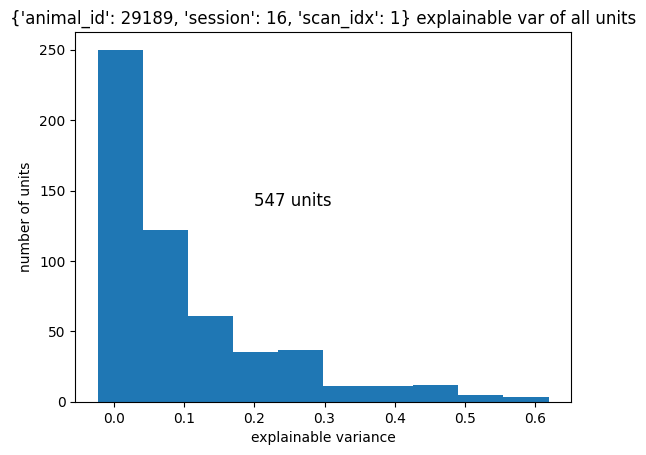

In [17]:
# all units 
plt.hist(exp_var)
plt.xlabel('explainable variance')
plt.ylabel('number of units')
plt.text(0.2, int(np.shape(responses_all)[2]/4), f'{np.shape(responses_all)[2]} units',  ha='left', va='bottom', fontsize = 12)
plt.title(f'{key} explainable var of all units')
#plt.savefig(f'4_{key}_expl_var_all.pdf')